In [1]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import copy
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tensorflow.python.keras.models import Sequential, Model, load_model
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

In [3]:
X_test = np.load('./X_test201_2.npy')
y_test = np.load('./y_test201_2.npy')
print(X_test.shape, y_test.shape)

(5000, 256, 256, 1) (5000, 4)


In [4]:
# Normalize data
scalery = MinMaxScaler()
scalery.fit(y_test)
y_test = scalery.transform(y_test)

In [5]:
# Load saved model
model   = load_model("./BestDAS_Resnet202_02.h5")

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [6]:
scores = model.evaluate(X_test, y_test, verbose=2)

5000/1 - 9s - loss: 0.0025 - mae: 0.0385


In [7]:
# Get the predictions
pred   = model.predict(X_test)
preds  = scalery.inverse_transform(pred)
y_tests= scalery.inverse_transform(y_test)

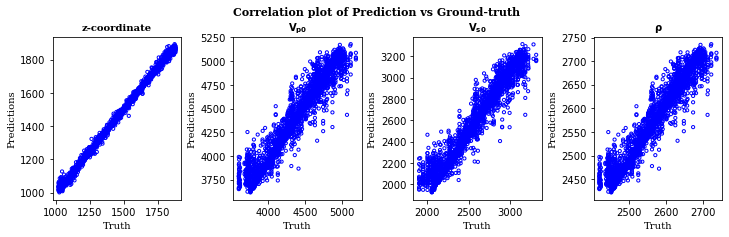

In [113]:
fig = plt.figure(figsize=(12,3))
gs  = gridspec.GridSpec(1,4, width_ratios=[1,1,1,1], hspace=0.3, wspace=0.4)
fig.suptitle('Correlation plot of Prediction vs Ground-truth', fontname='serif', fontsize=11, fontweight='bold', y=1.02)
# Plot z Coordinates
ax1  = plt.subplot(gs[0])
ax1.scatter(y_tests[:,0], preds[:,0],facecolors='none', edgecolors='b', s=10)
ax1.set_title('z-coordinate', fontname='serif', fontsize=10, fontweight='bold')
ax1.set_xlabel('Truth', fontname='serif')

ax1.set_ylabel('Predictions', fontname='serif')

# Plot vp
ax2  = plt.subplot(gs[1])
ax2.scatter(y_tests[:,1], preds[:,1],facecolors='none', edgecolors='b', s=10)
ax2.set_title(r'$\mathbf{V_{p0}}$', fontname='serif', fontsize=10, fontweight='bold')
ax2.set_xlabel('Truth', fontname='serif')
ax2.set_ylabel('Predictions', fontname='serif')

# Plot vs
ax3  = plt.subplot(gs[2])
ax3.scatter(y_tests[:,2], preds[:,2],facecolors='none', edgecolors='b', s=10)
ax3.set_title(r"$\mathbf{V_{s0}}$", fontname='serif', fontsize=10, fontweight='bold')
ax3.set_xlabel('Truth', fontname='serif')
ax3.set_ylabel('Predictions', fontname='serif')

# Plot rho 
ax4  = plt.subplot(gs[3])
ax4.scatter(y_tests[:,3], preds[:,3],facecolors='none', edgecolors='b', s=10)
ax4.set_title(r'$\mathbf{\rho}$', fontname='serif', fontsize=10, fontweight='bold')
ax4.set_xlabel('Truth', fontname='serif')
ax4.set_ylabel('Predictions', fontname='serif')

# plt.savefig('./Correlation_plot_Resnet202_021.png', bbox_inches='tight', dpi=800)
plt.show()

In [8]:
# Error analysis
# y_tests = y_test
errors= (preds - y_tests)
msez, msep = np.mean(np.absolute(errors[:,0]))*100/(np.mean(y_tests[:,0])), np.mean(np.absolute(errors[:,1]))*100/(np.mean(y_tests[:,1]))
mses ,mser = np.mean(np.absolute(errors[:,2]))*100/(np.mean(y_tests[:,2])), np.mean(np.absolute(errors[:,3]))*100/(np.mean(y_tests[:,3]))

print(msez, msep, mses, mser)

0.5097577751937505 1.8054849041877252 2.3756942895789743 0.6208546204785376


In [9]:
# av_errors = np.mean(errors)
stdz, stdp = np.std(errors[:,0])*100/np.std(y_tests[:,0]), np.std(errors[:,1])*100/np.std(y_tests[:,1])
stds, stdr = np.std(errors[:,2])*100/np.std(y_tests[:,2]), np.std(errors[:,3])*100/np.std(y_tests[:,3])
print(stdz, stdp, stds, stdr)

4.2759739497628955 27.757550703787743 25.828874502875728 27.96254306175156


In [10]:
# calculate interquartile range
iqrz, iqrp = stats.iqr(errors[:,0], interpolation='midpoint'), stats.iqr(errors[:,1], interpolation='midpoint')
iqrs, iqrr = stats.iqr(errors[:,2], interpolation='midpoint'), stats.iqr(errors[:,3], interpolation='midpoint')
print(iqrz, iqrp, iqrs, iqrr)

10.445751953124955 129.48583984375 105.80175781250023 26.462402343749773


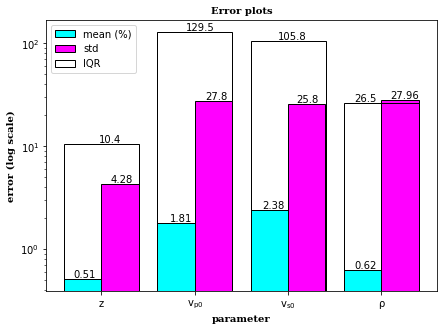

In [100]:
# Histogram plot for DAS
fig, ax = plt.subplots(figsize=(7,5))

mean = [msez, msep, mses, mser]
std  = [stdz, stdp, stds, stdr]
ermax= [iqrz, iqrp, iqrs, iqrr]

width = 0.40

# Set position on X-axis
p1 = np.arange(len(mean))
p2 = [i + width for i in p1]
# p3 = [i + width for i in p2]
p3 = p1+0.2

# Make the plot
plt.bar(p1, mean, color='cyan', width=width,edgecolor='black', label='mean (%)')
plt.bar(p2, std, color='fuchsia', width=width,edgecolor='black', label='std')
plt.bar(p3, ermax, color='none', width=width*2.01,edgecolor='black', label='IQR')

# Add xticks on the middle of the group bars
plt.xlabel('parameter', fontname='serif', fontweight='bold')
plt.ylabel('error (log scale)',fontname='serif', fontweight='bold')
plt.xticks([j + width-0.2 for j in range(len(mean))], [r'$\mathsf{z}$',r'$\mathsf{v_{p0}}$', r'$\mathsf{v_{s0}}$',r'$\mathsf{\rho}$'])
plt.yscale('log')
plt.title('Error plots', fontsize=10,fontname='serif', fontweight='bold')
# ax. set_yticklabels([])

plt.text(-0.1, round(msez,2)+0.02,round(msez,2))
plt.text(0.3, round(stdz,2)+0.2,round(stdz,2))
plt.text(0.17, round(iqrz,1)+.5,round(iqrz,1))

plt.text(0.93, round(msep,2)+0.05,round(msep,2))
plt.text(1.31, round(stdp,2)+1.0,round(stdp,1))
plt.text(1.1, round(iqrp,1)+5,round(iqrp,1))

plt.text(1.92, round(mses,2)+0.09,round(mses,2))
plt.text(2.29, round(stds,1)+1.0,round(stds,1))
plt.text(2.09, round(iqrs,1)+5,round(iqrs,1))

plt.text(2.91, round(mser,2)+0.02,round(mser,2))
plt.text(3.29, round(stdr,2)+1, round(stdr,2))
plt.text(2.91, round(iqrr,1)+1,round(iqrr,1))

plt.legend(loc='upper left')
plt.savefig('./DAS_Resnet202_02_Error_plots.png',bbox_inches = "tight", dpi=800)
plt.show()

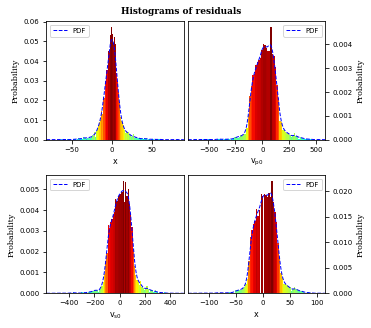

In [29]:
# display wavelet
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
import scipy.stats as st
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

x, vp, vs, rh = errors[:,0], errors[:,1], errors[:,2], errors[:,3]

# Bins for x
xq25, xq75 = np.percentile(x,[.25,.75])
xbin_width = 2*(xq75 - xq25)*len(x)**(-1/3)
xn_bins = round((x.max() - x.min())/xbin_width).astype(int)

# Bins for vp
vpq25, vpq75 = np.percentile(vp,[.25,.75])
vpbin_width = 2*(vpq75 - vpq25)*len(vp)**(-1/3)
vpn_bins = round((vp.max() - vp.min())/vpbin_width).astype(int)

# Bins for vs
vsq25, vsq75 = np.percentile(vs,[.25,.75])
vsbin_width = 2*(vsq75 - vsq25)*len(vs)**(-1/3)
vsn_bins = round((vs.max() - vs.min())/vsbin_width).astype(int)

# Bins for rho
rhq25, rhq75 = np.percentile(rh,[.25,.75])
rhbin_width = 2*(rhq75 - rhq25)*len(rh)**(-1/3)
rhn_bins = round((rh.max() - rh.min())/rhbin_width).astype(int)
  
    

fig = plt.figure(figsize=(5,5))
gs  = gridspec.GridSpec(2,2, height_ratios=[1,1], width_ratios=[1,1], wspace=0.03, hspace=0.3)
fig.suptitle('Histograms of residuals', fontname='serif', fontsize=9, fontweight='bold', y=0.92)

# Histogram for x
ax1  = plt.subplot(gs[0])
xN, xbins, xpatches = ax1.hist(x, density=True, bins = xn_bins, rwidth=.99)
## Set color
xfracs = ((xN**(1 / 5)) / xN.max())
xnorm = colors.Normalize(xfracs.min(), xfracs.max())

for thisfrac, thispatch in zip(xfracs, xpatches):
    xcolor = plt.cm.jet(xnorm(thisfrac))
    thispatch.set_facecolor(xcolor)

xmn, xmx = plt.xlim()
plt.xlim(xmn, xmx)    

xkde_xs = np.linspace(xmn, xmx, 500)
xkde = st.gaussian_kde(x)
ax1.plot(xkde_xs, xkde.pdf(xkde_xs),'--', color='blue',lw=1, label="PDF")
ax1.legend(loc="upper left", fontsize=7)
ax1.set_ylabel('Probability', fontsize=8, fontname='serif')
ax1.set_xlabel(r'$\mathsf{x}$', fontsize=8)
# ax1.yaxis.tick_right()
# ax1.yaxis.set_label_position('right')
ax1.tick_params(axis='both', labelsize=7)

# Histogram for vp
ax2  = plt.subplot(gs[1])
vpN, vpbins, vppatches = ax2.hist(vp, density=True, bins = vpn_bins, rwidth=.99)
## Set color
vpfracs = ((vpN**(1 / 5)) / vpN.max())
vpnorm = colors.Normalize(vpfracs.min(), vpfracs.max())

for thisfrac, thispatch in zip(vpfracs, vppatches):
    vpcolor = plt.cm.jet(vpnorm(thisfrac))
    thispatch.set_facecolor(vpcolor)

vpmn, vpmx = plt.xlim()
plt.xlim(vpmn, vpmx)    

vpkde_xs = np.linspace(vpmn, vpmx, 500)
vpkde = st.gaussian_kde(vp)
ax2.plot(vpkde_xs, vpkde.pdf(vpkde_xs),'--', color='blue',lw=1, label="PDF")
ax2.legend(loc="upper right", fontsize=7)
ax2.set_ylabel('Probability', fontsize=8, fontname='serif')
ax2.set_xlabel(r'$\mathsf{v_{p0}}$', fontsize=8)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='both', labelsize=7)
ax2.tick_params(axis='both', labelsize=7)
# ax2.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False,
#                      bottom=True, top=False, left=False, right=True)


# Histogram for vs
ax3  = plt.subplot(gs[2])
vsN, vsbins, vspatches = ax3.hist(vs, density=True, bins = vsn_bins, rwidth=.99)
## Set color
vsfracs = ((vsN**(1 / 5)) / vsN.max())
vsnorm = colors.Normalize(vsfracs.min(), vsfracs.max())

for thisfrac, thispatch in zip(vsfracs, vspatches):
    vscolor = plt.cm.jet(vsnorm(thisfrac))
    thispatch.set_facecolor(vscolor)

vsmn, vsmx = plt.xlim()
plt.xlim(vsmn, vsmx)    

vskde_xs = np.linspace(vsmn, vsmx, 500)
vskde = st.gaussian_kde(vs)
ax3.plot(vskde_xs, vskde.pdf(vskde_xs),'--', color='blue',lw=1, label="PDF")
ax3.legend(loc="upper left", fontsize=7)
ax3.set_ylabel('Probability', fontsize=8, fontname='serif')
ax3.set_xlabel(r'$\mathsf{v_{s0}}$', fontsize=8)
# ax1.yaxis.tick_right()
# ax1.yaxis.set_label_position('right')
ax3.tick_params(axis='both', labelsize=7)

# Histogram for rho
ax4  = plt.subplot(gs[3])
rhN, rhbins, rhpatches = ax4.hist(rh, density=True, bins = rhn_bins, rwidth=.99)
## Set color
rhfracs = ((rhN**(1 / 5)) / rhN.max())
rhnorm = colors.Normalize(rhfracs.min(), rhfracs.max())

for thisfrac, thispatch in zip(rhfracs, rhpatches):
    rhcolor = plt.cm.jet(rhnorm(thisfrac))
    thispatch.set_facecolor(rhcolor)

rhmn, rhmx = plt.xlim()
plt.xlim(rhmn, rhmx)    

rhkde_xs = np.linspace(rhmn, rhmx, 500)
rhkde = st.gaussian_kde(rh)
ax4.plot(rhkde_xs, rhkde.pdf(rhkde_xs),'--', color='blue',lw=1, label="PDF")
ax4.legend(loc="upper right", fontsize=7)
ax4.set_ylabel('Probability', fontsize=8, fontname='serif')
ax4.set_xlabel(r'$\mathsf{x}$', fontsize=8)
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position('right')
ax4.tick_params(axis='both', labelsize=7)

plt.savefig('./Combined_Histograms.png', dpi=800, bbox_inches='tight')
plt.show()

In [73]:
src = np.load("./Data/Sources_DAS202c.npy")
print(src.shape)

(50, 100, 7)


In [74]:
src = src.reshape(src.shape[0]*src.shape[1], src.shape[2])
print(src.shape)

(5000, 7)


In [75]:
xcord = src[:,0]
locTrue = np.c_[xcord, y_tests[:,0]]
locPred = np.c_[xcord, preds[:,0]]

In [76]:
print(locTrue.shape, locPred.shape)

(5000, 2) (5000, 2)


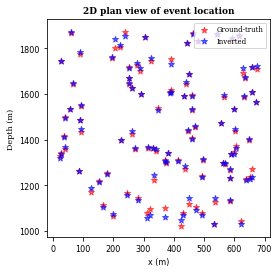

In [112]:
plt.figure(figsize=(4,4))
plt.scatter(locTrue[:100,0], locTrue[:100,1], marker='*',facecolors='red', edgecolors='red', s=40, alpha=0.6,label='Ground-truth')
plt.scatter(locPred[:100,0], locPred[:100,1], marker='*',facecolors='blue', edgecolors='blue', s=40, alpha=0.6, label='Inverted')
plt.title('2D plan view of event location', fontname='serif', fontsize=9, fontweight='bold')
plt.ylabel('Depth (m)', fontname='serif', fontsize=8)
plt.xlabel('x (m)', fontsize=8)
plt.tick_params(labelsize=8)
plt.legend(loc='upper right', prop={'family':'serif','size':7})
plt.savefig('./Plan_view.png', bbox_inches='tight', dpi=800)
plt.show()

In [62]:
velTrue = y_tests.reshape(50,100,4)
velPred = preds.reshape(50,100,4)

In [63]:
vmodelsort, vmodel_predsort = [],[]
for i in range(50):
    vmodel = velTrue[i]
    vmodelsorts = vmodel[vmodel[:,0].argsort()]
    vmodelsort.append(vmodelsorts)
    
    vmodelPred = velPred[i]
    vmodel_predsorts=vmodelPred[vmodelPred[:,0].argsort()]
    vmodel_predsort.append(vmodel_predsorts)
vmodelsort, vmodel_predsort = np.array(vmodelsort), np.array(vmodel_predsort)

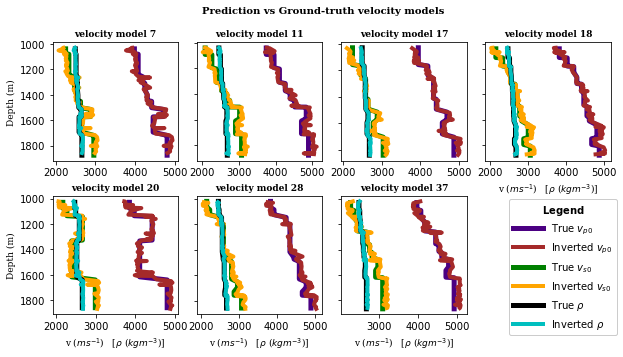

In [79]:
fig = plt.figure(figsize=(10,5))
gs  = gridspec.GridSpec(2,4, width_ratios=[1,1,1,1], height_ratios=[1,1], hspace=0.3, wspace=0.15)
fig.suptitle('Prediction vs Ground-truth velocity models', fontname='serif', fontsize=10, fontweight='bold', y=.98)

i = 6
ax1  = plt.subplot(gs[0])
ax1.plot(vmodelsort[i,:,1], vmodelsort[i,:,0], 'indigo', linewidth=5, label = 'True $v_p$')
ax1.plot(vmodel_predsort[i,:,1], vmodel_predsort[i,:,0], color='brown', linewidth=4, label = 'Inverted $v_p$')
ax1.plot(vmodelsort[i,:,2], vmodelsort[i,:,0], 'g', linewidth=5, label = 'True $v_s$')
ax1.plot(vmodel_predsort[i,:,2], vmodel_predsort[i,:,0], color='orange',linewidth=4, label = 'Inverted $v_s$')
ax1.plot(vmodelsort[i,:,3], vmodelsort[i,:,0], 'k', linewidth=5, label = r'True $\rho$')
ax1.plot(vmodel_predsort[i,:,3], vmodel_predsort[i,:,0],'c',linewidth=4, label = r'Inverted $\rho$')
ax1.set_ylabel('Depth (m)', fontsize=9, fontname='serif')
ax1.set_title('velocity model %d'%(i+1), fontsize=9, fontname='serif', fontweight='bold')
plt.gca().invert_yaxis()

i = 10
ax2  = plt.subplot(gs[1])
ax2.plot(vmodelsort[i,:,1], vmodelsort[i,:,0], 'indigo', linewidth=5, label = 'True $v_p$')
ax2.plot(vmodel_predsort[i,:,1], vmodel_predsort[i,:,0], color='brown', linewidth=4, label = 'Inverted $v_p$')
ax2.plot(vmodelsort[i,:,2], vmodelsort[i,:,0], 'g', linewidth=5, label = 'True $v_s$')
ax2.plot(vmodel_predsort[i,:,2], vmodel_predsort[i,:,0], color='orange',linewidth=4, label = 'Inverted $v_s$')
ax2.plot(vmodelsort[i,:,3], vmodelsort[i,:,0], 'k', linewidth=5, label = r'True $\rho$')
ax2.plot(vmodel_predsort[i,:,3], vmodel_predsort[i,:,0],'c',linewidth=4, label = r'Inverted $\rho$')
ax2.set_title('velocity model %d'%(i+1), fontsize=9, fontname='serif', fontweight='bold')
ax2.axes.yaxis.set_ticklabels([])
plt.gca().invert_yaxis()

i = 16
ax3  = plt.subplot(gs[2])
ax3.plot(vmodelsort[i,:,1], vmodelsort[i,:,0], 'indigo', linewidth=5, label = 'True $v_p$')
ax3.plot(vmodel_predsort[i,:,1], vmodel_predsort[i,:,0], color='brown', linewidth=4, label = 'Inverted $v_p$')
ax3.plot(vmodelsort[i,:,2], vmodelsort[i,:,0], 'g', linewidth=5, label = 'True $v_s$')
ax3.plot(vmodel_predsort[i,:,2], vmodel_predsort[i,:,0], color='orange',linewidth=4, label = 'Inverted $v_s$')
ax3.plot(vmodelsort[i,:,3], vmodelsort[i,:,0], 'k', linewidth=5, label = r'True $\rho$')
ax3.plot(vmodel_predsort[i,:,3], vmodel_predsort[i,:,0],'c',linewidth=4, label = r'Inverted $\rho$')
ax3.set_title('velocity model %d'%(i+1), fontsize=9, fontname='serif', fontweight='bold')
ax3.axes.yaxis.set_ticklabels([])
plt.gca().invert_yaxis()

i = 17
ax4  = plt.subplot(gs[3])
ax4.plot(vmodelsort[i,:,1], vmodelsort[i,:,0], 'indigo', linewidth=5, label = 'True $v_p$')
ax4.plot(vmodel_predsort[i,:,1], vmodel_predsort[i,:,0], color='brown', linewidth=4, label = 'Inverted $v_{p}$')
ax4.plot(vmodelsort[i,:,2], vmodelsort[i,:,0], 'g', linewidth=5, label = 'True $v_s$')
ax4.plot(vmodel_predsort[i,:,2], vmodel_predsort[i,:,0], color='orange',linewidth=4, label = 'Inverted $v_s$')
ax4.plot(vmodelsort[i,:,3], vmodelsort[i,:,0], 'k', linewidth=5, label = r'True $\rho$')
ax4.plot(vmodel_predsort[i,:,3], vmodel_predsort[i,:,0],'c',linewidth=4, label = r'Inverted $\rho$')
ax4.set_xlabel('v ($ms^{-1}$)\t'+ r'[$\rho$ ($kgm^{-3}$)]', fontsize=9, fontname='serif')
ax4.set_title('velocity model %d'%(i+1), fontsize=9, fontname='serif', fontweight='bold')
ax4.axes.yaxis.set_ticklabels([])
plt.gca().invert_yaxis()

i = 19
ax5  = plt.subplot(gs[4])
ax5.plot(vmodelsort[i,:,1], vmodelsort[i,:,0], 'indigo', linewidth=5, label = 'True $v_p$')
ax5.plot(vmodel_predsort[i,:,1], vmodel_predsort[i,:,0], color='brown', linewidth=4, label = 'Inverted $v_p$')
ax5.plot(vmodelsort[i,:,2], vmodelsort[i,:,0], 'g', linewidth=5, label = 'True $v_s$')
ax5.plot(vmodel_predsort[i,:,2], vmodel_predsort[i,:,0], color='orange',linewidth=4, label = 'Inverted $v_s$')
ax5.plot(vmodelsort[i,:,3], vmodelsort[i,:,0], 'k', linewidth=5, label = r'True $\rho$')
ax5.plot(vmodel_predsort[i,:,3], vmodel_predsort[i,:,0],'c',linewidth=4, label = r'Inverted $\rho$')
ax5.set_ylabel('Depth (m)', fontsize=9, fontname='serif')
ax5.set_xlabel('v ($ms^{-1}$)\t'+ r'[$\rho$ ($kgm^{-3}$)]', fontsize=9, fontname='serif')
ax5.set_title('velocity model %d'%(i+1), fontsize=9, fontname='serif', fontweight='bold')
plt.gca().invert_yaxis()

i = 27
ax6  = plt.subplot(gs[5])
ax6.plot(vmodelsort[i,:,1], vmodelsort[i,:,0], 'indigo', linewidth=5, label = 'True $v_p$')
ax6.plot(vmodel_predsort[i,:,1], vmodel_predsort[i,:,0], color='brown', linewidth=4, label = 'Inverted $v_p$')
ax6.plot(vmodelsort[i,:,2], vmodelsort[i,:,0], 'g', linewidth=5, label = 'True $v_s$')
ax6.plot(vmodel_predsort[i,:,2], vmodel_predsort[i,:,0], color='orange',linewidth=4, label = 'Inverted $v_s$')
ax6.plot(vmodelsort[i,:,3], vmodelsort[i,:,0], 'k', linewidth=5, label = r'True $\rho$')
ax6.plot(vmodel_predsort[i,:,3], vmodel_predsort[i,:,0],'c',linewidth=4, label = r'Inverted $\rho$')
ax6.set_xlabel('v ($ms^{-1}$)\t'+ r'[$\rho$ ($kgm^{-3}$)]', fontsize=9, fontname='serif')
ax6.set_title('velocity model %d'%(i+1), fontsize=9, fontname='serif', fontweight='bold')
ax6.axes.yaxis.set_ticklabels([])
plt.gca().invert_yaxis()

i = 36
ax7  = plt.subplot(gs[6])
ax7.plot(vmodelsort[i,:,1], vmodelsort[i,:,0], 'indigo', linewidth=5, label = 'True $v_{p0}$')
ax7.plot(vmodel_predsort[i,:,1], vmodel_predsort[i,:,0], color='brown', linewidth=4, label = 'Inverted $v_{p0}$')
ax7.plot(vmodelsort[i,:,2], vmodelsort[i,:,0], 'g', linewidth=5, label = 'True $v_{s0}$')
ax7.plot(vmodel_predsort[i,:,2], vmodel_predsort[i,:,0], color='orange',linewidth=4, label = 'Inverted $v_{s0}$')
ax7.plot(vmodelsort[i,:,3], vmodelsort[i,:,0], 'k', linewidth=5, label = r'True $\rho$')
ax7.plot(vmodel_predsort[i,:,3], vmodel_predsort[i,:,0],'c',linewidth=4, label = r'Inverted $\rho$')
ax7.set_xlabel('v ($ms^{-1}$)\t'+ r'[$\rho$ ($kgm^{-3}$)]', fontsize=9, fontname='serif')
ax7.set_title('velocity model %d'%(i+1), fontsize=9, fontname='serif', fontweight='bold')
ax7.axes.yaxis.set_ticklabels([])
plt.gca().invert_yaxis()

plt.gca().legend(loc='center left', title='$\mathbf{Legend}$',bbox_to_anchor=(1.3, 0.4), framealpha=1, handlelength=3)

ax4.yaxis.set_label_position('right')
plt.savefig('./vmodelplot.png', dpi=800, bbox_inches='tight')
plt.show()